# SHROOM Dataset Analysis

### Arshan Dalili - Modeling Semantic Plausibility Seminar

## Importing some of the required libraries

We will import other libraries as we move forward.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import plotly.graph_objects as go
import evaluate
from tabulate import tabulate

## Reading the dataset

In [15]:
train_df = pd.read_json('./data/shroom/train-dev-test-split/SHROOM_unlabeled-training-data-v2/train.model-agnostic.json')
val_df = pd.read_json('./data/shroom/train-dev-test-split/SHROOM_dev-v2/val.model-agnostic.json')
test_df = pd.read_json('./data/shroom/train-dev-test-split/SHROOM_test-labeled/test.model-agnostic.json')

In [16]:
train_df.head()

,hyp,tgt,src,ref,task,model
0,"Don't worry, it's only temporary.",Don't worry. It's only temporary.,Не волнуйся. Это только временно.,either,MT,
1,Tom is never where he should be.,Tom is never where he's supposed to be.,"Тома никогда нет там, где он должен быть.",either,MT,
2,It's hard for me to work with Tom.,I have trouble working with Tom.,Мне сложно работать с Томом.,either,MT,
3,"Water, please.",I'd like some water.,"Воду, пожалуйста.",either,MT,
4,I didn't expect Tom to betray me.,I didn't think that Tom would betray me.,"Я не ожидал, что Том предаст меня.",either,MT,


In [17]:
val_df.head()

,hyp,ref,src,tgt,model,task,labels,label,p(Hallucination)
0,Resembling or characteristic of a weasel.,tgt,The writer had just entered into his eighteent...,Resembling a weasel (in appearance).,,DM,"[Hallucination, Not Hallucination, Not Halluci...",Not Hallucination,0.2
1,Alternative form of sheath knife,tgt,Sailors ' and fishermen 's <define> sheath - k...,.,,DM,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,0.8
2,(obsolete) A short period of time.,tgt,"As to age , Bead could not form any clear impr...","(poetic) An instant, a short moment.",,DM,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.0
3,(slang) An incel.,tgt,Because redpillers are usually normies or <def...,"(incel, _, slang) A man of a slightly lower ra...",,DM,"[Not Hallucination, Not Hallucination, Halluci...",Not Hallucination,0.2
4,"An island in Lienchiang County, Taiwan.",tgt,On the second day of massive live - fire drill...,"An island in Dongyin, Lienchiang, Taiwan, in t...",,DM,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.0


In [18]:
test_df.head()

,id,src,tgt,hyp,task,labels,label,p(Hallucination)
0,1,"Ты удивишься, если я скажу, что на самом деле ...",Would you be surprised if I told you my name i...,You're gonna be surprised if I say my real nam...,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.0
1,2,Еды будет полно.,There will be plenty of food.,The food will be full.,MT,"[Hallucination, Not Hallucination, Hallucinati...",Hallucination,0.8
2,3,"Думаете, Том будет меня ждать?",Do you think that Tom will wait for me?,You think Tom's gonna wait for me?,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.2
3,6,Два брата довольно разные.,The two brothers are pretty different.,There's a lot of friends.,MT,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,1.0
4,7,<define> Infradiaphragmatic </define> intra- a...,(medicine) Below the diaphragm.,(anatomy) Relating to the diaphragm.,DM,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,0.8


## Analysing the dataset with its characteristics

### Characteritic 1: Text Complexity

Here, we will analyze the text complexity of the dataset. We will use the following metrics to analyze the text complexity: `Flesch Reading Ease`, `SMOG Index`, and `Gunning Fog Index`.

As a reminder, the Flesch Reading Ease score is a text readability test that rates the text on a 100-point scale. The higher the score, the easier it is to understand the document.

The SMOG Index is a readability test that estimate the years of education a person needs to understand a piece of text. The higher the score, the more difficult the text is to read. It is usually perferred for longer texts.

In [ ]:
from textstat import flesch_reading_ease, flesch_kincaid_grade, smog_index

# Copy src to tgt where task is PG
train_df_tc = train_df.copy()
val_df_tc = val_df.copy()
test_df_tc = test_df.copy()
train_df_tc.loc[train_df_tc['task'] == 'PG', 'tgt'] = train_df_tc.loc[train_df_tc['task'] == 'PG', 'src']
val_df_tc.loc[val_df_tc['task'] == 'PG', 'tgt'] = val_df_tc.loc[val_df_tc['task'] == 'PG', 'src']
test_df_tc.loc[test_df_tc['task'] == 'PG', 'tgt'] = test_df_tc.loc[test_df_tc['task'] == 'PG', 'src']

# Combine all hypothesis and target text into one string
## Hypothesis
train_hyp_text = ' '.join(train_df_tc['hyp'].to_list())
val_hyp_text = ' '.join(val_df_tc['hyp'].to_list())
test_hyp_text = ' '.join(test_df_tc['hyp'].to_list())

## Target
train_tgt_text = ' '.join(train_df_tc['tgt'].to_list())
val_tgt_text = ' '.join(train_df_tc['tgt'].to_list())
test_tgt_text = ' '.join(train_df_tc['tgt'].to_list())

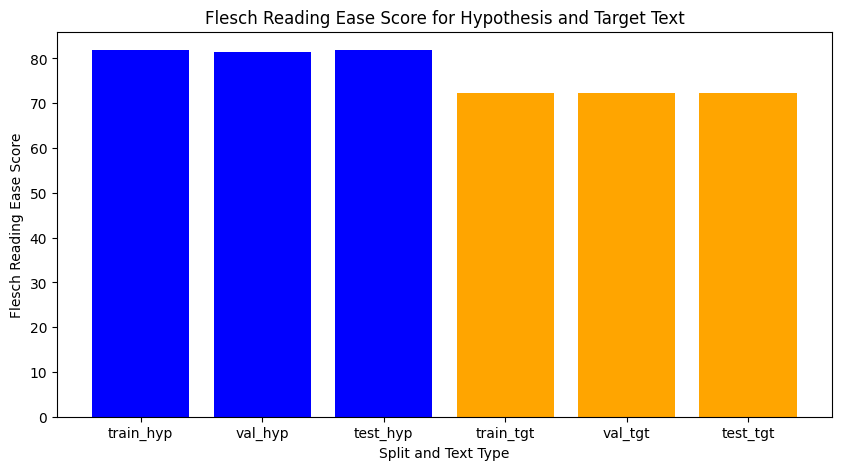

In [ ]:
# Calculate Flesch reading ease score
## Hypothesis
train_hyp_flesch_score = flesch_reading_ease(train_hyp_text)
val_hyp_flesch_score = flesch_reading_ease(val_hyp_text)
test_hyp_flesch_score = flesch_reading_ease(test_hyp_text)

## Target
train_tgt_flesch_score = flesch_reading_ease(train_tgt_text)
val_tgt_flesch_score = flesch_reading_ease(val_tgt_text)
test_tgt_flesch_score = flesch_reading_ease(test_tgt_text)

# Plot Flesch reading ease score using bar plot
plt.figure(figsize=(10, 5))
plt.bar(['train_hyp', 'val_hyp', 'test_hyp', 'train_tgt', 'val_tgt', 'test_tgt'], [train_hyp_flesch_score, val_hyp_flesch_score, test_hyp_flesch_score, train_tgt_flesch_score, val_tgt_flesch_score, test_tgt_flesch_score], color=['blue', 'blue', 'blue', 'orange', 'orange', 'orange'])
plt.xlabel('Split and Text Type')
plt.ylabel('Flesch Reading Ease Score')
plt.title('Flesch Reading Ease Score for Hypothesis and Target Text')
plt.show()


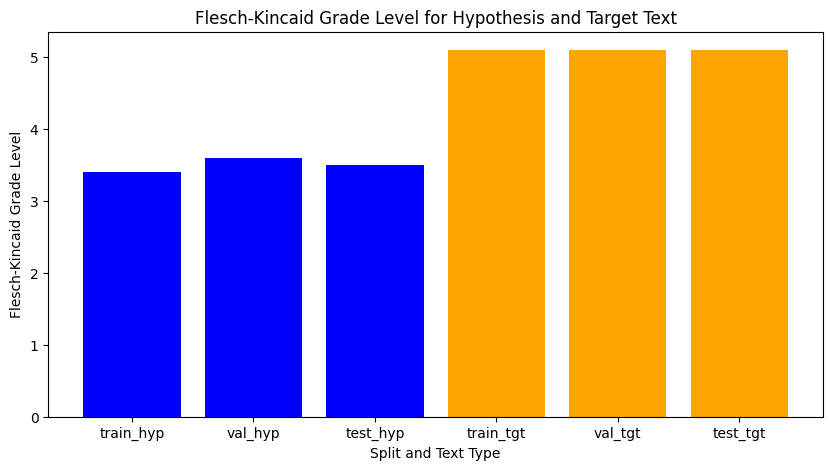

In [ ]:
# Calculate Flesch-Kincaid grade level
## Hypothesis
train_hyp_fk_score = flesch_kincaid_grade(train_hyp_text)
val_hyp_fk_score = flesch_kincaid_grade(val_hyp_text)
test_hyp_fk_score = flesch_kincaid_grade(test_hyp_text)

## Target
train_tgt_fk_score = flesch_kincaid_grade(train_tgt_text)
val_tgt_fk_score = flesch_kincaid_grade(val_tgt_text)
test_tgt_fk_score = flesch_kincaid_grade(test_tgt_text)

# Plot Flesch-Kincaid grade level using bar plot
plt.figure(figsize=(10, 5))
plt.bar(['train_hyp', 'val_hyp', 'test_hyp', 'train_tgt', 'val_tgt', 'test_tgt'], [train_hyp_fk_score, val_hyp_fk_score, test_hyp_fk_score, train_tgt_fk_score, val_tgt_fk_score, test_tgt_fk_score], color=['blue', 'blue', 'blue', 'orange', 'orange', 'orange'])
plt.xlabel('Split and Text Type')
plt.ylabel('Flesch-Kincaid Grade Level')
plt.title('Flesch-Kincaid Grade Level for Hypothesis and Target Text')
plt.show()

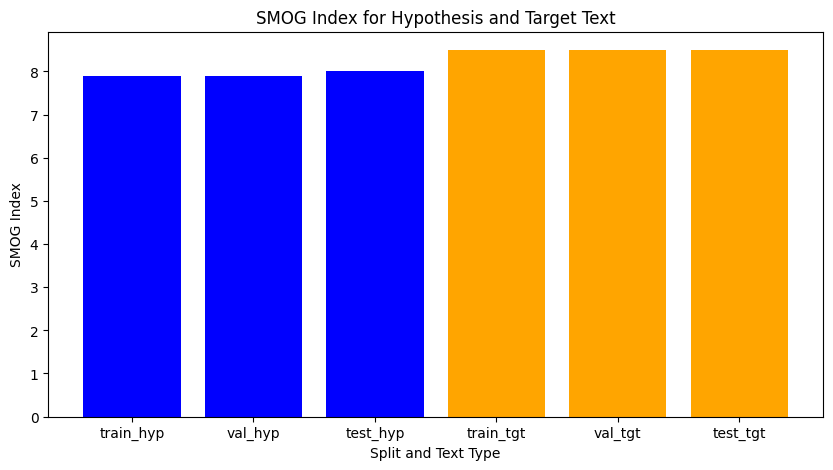

In [ ]:
# Calculate SMOG index
## Hypothesis
train_hyp_smog_score = smog_index(train_hyp_text)
val_hyp_smog_score = smog_index(val_hyp_text)
test_hyp_smog_score = smog_index(test_hyp_text)

## Target
train_tgt_smog_score = smog_index(train_tgt_text)
val_tgt_smog_score = smog_index(val_tgt_text)
test_tgt_smog_score = smog_index(test_tgt_text)

# Plot SMOG index using bar plot
plt.figure(figsize=(10, 5))
plt.bar(['train_hyp', 'val_hyp', 'test_hyp', 'train_tgt', 'val_tgt', 'test_tgt'], [train_hyp_smog_score, val_hyp_smog_score, test_hyp_smog_score, train_tgt_smog_score, val_tgt_smog_score, test_tgt_smog_score], color=['blue', 'blue', 'blue', 'orange', 'orange', 'orange'])
plt.xlabel('Split and Text Type')
plt.ylabel('SMOG Index')
plt.title('SMOG Index for Hypothesis and Target Text')
plt.show()

As you can see above, the Flesch Reading Ease score for the hypothesis is generally higher than the target, and in contrast, the Flesch-Kincaid Grade Level and SMOG Index for the hypothesis are lower than the target. This indicates that the hypothesis is generally less complex than the target. That might be because the hypothesis was generated by a model, which might not be able to generate complex sentences (i.e., the model might be biased towards simpler sentences). It might point out that the model generating the hypothesis might not be able to grasp the whole context of the target sentence and, therefore, falls short and hallucinates the target sentence.

### Characteritic 2: Abstractness and Concreteness

Here, we will analyze the abstractness and concreteness of the dataset. We will use the Abstractness and Concreteness scores from the [English Abstractness / Concreteness Ratings](https://www.ims.uni-stuttgart.de/en/research/resources/lexica/abst-ratings-en/).


In [ ]:
# Read the Concreteness dataset
concreteness_df = pd.read_csv('./data/ac_EN_ratings/AC_ratings_google3m_koeper_SiW.csv', sep='\t')
print(f'Max concreteness: {concreteness_df['RATING'].max()} for the word: {concreteness_df[concreteness_df["RATING"] == concreteness_df["RATING"].max()]["WORD"].values[0]}')
print(f'Min concreteness: {concreteness_df['RATING'].min()} for the word: {concreteness_df[concreteness_df["RATING"] == concreteness_df["RATING"].min()]["WORD"].values[0]}')
concreteness_df.head()

Max concreteness: 10.0 for the word: rubber_bracelets
Min concreteness: 0.0 for the word: egregiously


,WORD,RATING
0,in,1.389
1,for,0.951
2,that,0.639
3,is,1.053
4,on,1.871


In [ ]:
def calculate_sentence_concreteness(text, concreteness_df):
    words = word_tokenize(text)
    concreteness = []
    for word in words:
        if word in concreteness_df['WORD'].values:
            concreteness.append(concreteness_df[concreteness_df['WORD'] == word]['RATING'].values[0])
    return np.mean(concreteness)

In [ ]:
# Calculate concreteness score for each word in the hypothesis and target text
## 200 sample from the train, val, and test dataframes (to speed up the process)
train_df_concreteness = train_df.sample(200)
val_df_concreteness = val_df.sample(200)
test_df_concreteness = test_df.sample(200)
## Copy src to tgt columns where task is PG
train_df_concreteness.loc[train_df_concreteness['task'] == 'PG', 'tgt'] = train_df_concreteness.loc[train_df_concreteness['task'] == 'PG', 'src']
val_df_concreteness.loc[val_df_concreteness['task'] == 'PG', 'tgt'] = val_df_concreteness.loc[val_df_concreteness['task'] == 'PG', 'src']
test_df_concreteness.loc[test_df_concreteness['task'] == 'PG', 'tgt'] = test_df_concreteness.loc[test_df_concreteness['task'] == 'PG', 'src']

## Use tqdm to show progress bar
tqdm.pandas()

## Calculate concreteness score for hypothesis and target text in dataframes
train_df_concreteness['hyp_concreteness'] = train_df_concreteness['hyp'].progress_apply(lambda x: calculate_sentence_concreteness(x, concreteness_df))
train_df_concreteness['tgt_concreteness'] = train_df_concreteness['tgt'].progress_apply(lambda x: calculate_sentence_concreteness(x, concreteness_df))

val_df_concreteness['hyp_concreteness'] = val_df_concreteness['hyp'].progress_apply(lambda x: calculate_sentence_concreteness(x, concreteness_df))
val_df_concreteness['tgt_concreteness'] = val_df_concreteness['tgt'].progress_apply(lambda x: calculate_sentence_concreteness(x, concreteness_df))

test_df_concreteness['hyp_concreteness'] = test_df_concreteness['hyp'].progress_apply(lambda x: calculate_sentence_concreteness(x, concreteness_df))
test_df_concreteness['tgt_concreteness'] = test_df_concreteness['tgt'].progress_apply(lambda x: calculate_sentence_concreteness(x, concreteness_df))

 12%|█▏        | 23/200 [00:21<02:53,  1.02it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

 52%|█████▎    | 105/200 [01:31<01:21,  1.16it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

 87%|████████▋ | 174/200 [03:09<00:26,  1.02s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Train Hypothesis Concreteness Mean: 2.6420 +/- 0.9738
Train Target Concreteness Mean: 2.6211 +/- 1.0397
Val Hypothesis Concreteness Mean: 2.4185 +/- 1.0108
Val Target Concreteness Mean: 2.5074 +/- 1.0231
Test Hypothesis Concreteness Mean: 2.5195 +/- 1.0656
Test Target Concreteness Mean: 2.5246 +/- 1.0594


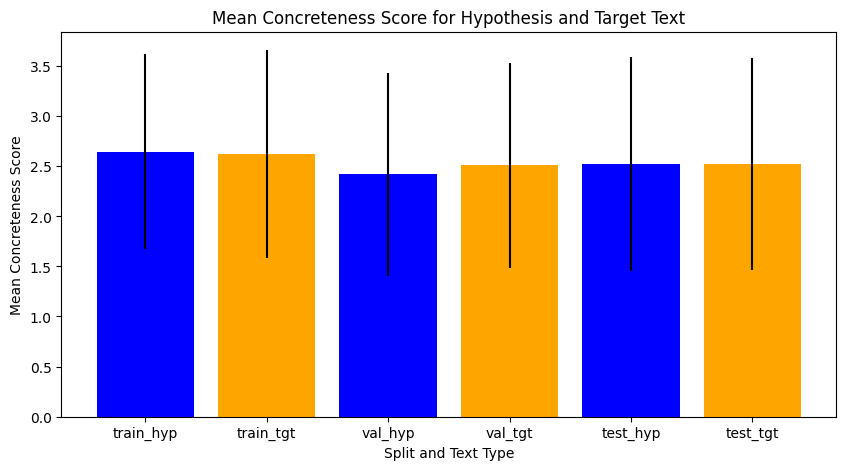

In [ ]:
## Calculate mean and standard deviation of concreteness score for hypothesis and target text
train_hyp_concreteness_mean = train_df_concreteness['hyp_concreteness'].mean()
train_hyp_concreteness_std = train_df_concreteness['hyp_concreteness'].std()

train_tgt_concreteness_mean = train_df_concreteness['tgt_concreteness'].mean()
train_tgt_concreteness_std = train_df_concreteness['tgt_concreteness'].std()

val_hyp_concreteness_mean = val_df_concreteness['hyp_concreteness'].mean()
val_hyp_concreteness_std = val_df_concreteness['hyp_concreteness'].std()

val_tgt_concreteness_mean = val_df_concreteness['tgt_concreteness'].mean()
val_tgt_concreteness_std = val_df_concreteness['tgt_concreteness'].std()

test_hyp_concreteness_mean = test_df_concreteness['hyp_concreteness'].mean()
test_hyp_concreteness_std = test_df_concreteness['hyp_concreteness'].std()

test_tgt_concreteness_mean = test_df_concreteness['tgt_concreteness'].mean()
test_tgt_concreteness_std = test_df_concreteness['tgt_concreteness'].std()

print(f'Train Hypothesis Concreteness Mean: {train_hyp_concreteness_mean:.4f} +/- {train_hyp_concreteness_std:.4f}')
print(f'Train Target Concreteness Mean: {train_tgt_concreteness_mean:.4f} +/- {train_tgt_concreteness_std:.4f}')
print(f'Val Hypothesis Concreteness Mean: {val_hyp_concreteness_mean:.4f} +/- {val_hyp_concreteness_std:.4f}')
print(f'Val Target Concreteness Mean: {val_tgt_concreteness_mean:.4f} +/- {val_tgt_concreteness_std:.4f}')
print(f'Test Hypothesis Concreteness Mean: {test_hyp_concreteness_mean:.4f} +/- {test_hyp_concreteness_std:.4f}')
print(f'Test Target Concreteness Mean: {test_tgt_concreteness_mean:.4f} +/- {test_tgt_concreteness_std:.4f}')

# Plot concreteness score using bar plot
plt.figure(figsize=(10, 5))
plt.bar(['train_hyp', 'train_tgt', 'val_hyp', 'val_tgt', 'test_hyp', 'test_tgt'], [train_hyp_concreteness_mean, train_tgt_concreteness_mean, val_hyp_concreteness_mean, val_tgt_concreteness_mean, test_hyp_concreteness_mean, test_tgt_concreteness_mean], yerr=[train_hyp_concreteness_std, train_tgt_concreteness_std, val_hyp_concreteness_std, val_tgt_concreteness_std, test_hyp_concreteness_std, test_tgt_concreteness_std], color=['blue', 'orange', 'blue', 'orange', 'blue', 'orange'])
plt.xlabel('Split and Text Type')
plt.ylabel('Mean Concreteness Score')
plt.title('Mean Concreteness Score for Hypothesis and Target Text')
plt.show()

In [ ]:
# Plot histogram for hypothesis and target text concreteness score
fig = go.Figure()
fig.add_trace(go.Histogram(x=train_df_concreteness['hyp_concreteness'], name='train_hyp', marker_color='blue', opacity=0.5))
fig.add_trace(go.Histogram(x=train_df_concreteness['tgt_concreteness'], name='train_tgt', marker_color='red', opacity=0.5))
fig.add_trace(go.Histogram(x=val_df_concreteness['hyp_concreteness'], name='val_hyp', marker_color='orange', opacity=0.5))
fig.add_trace(go.Histogram(x=val_df_concreteness['tgt_concreteness'], name='val_tgt', marker_color='purple', opacity=0.5))
fig.add_trace(go.Histogram(x=test_df_concreteness['hyp_concreteness'], name='test_hyp', marker_color='green', opacity=0.5))
fig.add_trace(go.Histogram(x=test_df_concreteness['tgt_concreteness'], name='test_tgt', marker_color='brown', opacity=0.5))
fig.update_layout(barmode='group', title='Concreteness Score for Hypothesis and Target Text')
fig.show()

As you can see above, the concreteness scores distribution for both the hypothesis and the target is very similar. However, the thing to note is that the concreteness scores' mean reduces for the validation and test sets. This means the sentences in the validation and test sets are more abstract than in the training set. This might make the validation and test sets more challenging to generate hypotheses for, as the model might not be able to generate abstract sentences as well as concrete sentences.

### Characteritic 3: NLG Evaluation of the output

Here, we will analyze the output of the model. We will use the following metrics to analyze the output: `BLEU` and `BERTScore`

BLEU is a metric for evaluating a generated sentence to a reference sentence. It is based on the n-gram precision between the generated sentence and the reference sentence. The BLEU score ranges from 0 to 1, where 1 means the generated sentence is identical to the reference sentence.

BERTScore (Precision, Recall, F1) is a metric for evaluating the similarity between two sentences. It provides a more sophisticated assessment of semantic similarity and context.

In [ ]:
# Load BLEU and BERTScore metrics
bleu = evaluate.load('bleu')
bertscore = evaluate.load('bertscore')

# Calculate BLEU score for hypothesis and target text
train_nlg_df = train_df.copy()
val_nlg_df = val_df.copy()
test_nlg_df = test_df.copy()
## Copy src to tgt columns where task is PG
train_nlg_df.loc[train_nlg_df['task'] == 'PG', 'tgt'] = train_nlg_df.loc[train_nlg_df['task'] == 'PG', 'src']
val_nlg_df.loc[val_nlg_df['task'] == 'PG', 'tgt'] = val_nlg_df.loc[val_nlg_df['task'] == 'PG', 'src']
test_nlg_df.loc[test_nlg_df['task'] == 'PG', 'tgt'] = test_nlg_df.loc[test_nlg_df['task'] == 'PG', 'src']

In [ ]:
train_nlg_df

,hyp,tgt,src,ref,task,model
0,"Don't worry, it's only temporary.",Don't worry. It's only temporary.,Не волнуйся. Это только временно.,either,MT,
1,Tom is never where he should be.,Tom is never where he's supposed to be.,"Тома никогда нет там, где он должен быть.",either,MT,
2,It's hard for me to work with Tom.,I have trouble working with Tom.,Мне сложно работать с Томом.,either,MT,
3,"Water, please.",I'd like some water.,"Воду, пожалуйста.",either,MT,
4,I didn't expect Tom to betray me.,I didn't think that Tom would betray me.,"Я не ожидал, что Том предаст меня.",either,MT,
...,...,...,...,...,...,...
29995,"Yeah, I'm listening.","Yeah, I'm listening.","Yeah, I'm listening.",src,PG,
29996,Time?,The time?,The time?,src,PG,
29997,Plague?,A plague?,A plague?,src,PG,
29998,"Tango, Tango.",Tango.,Tango.,src,PG,


Train BLEU Score: 0.2744
Val BLEU Score: 0.1888
Test BLEU Score: 0.1727


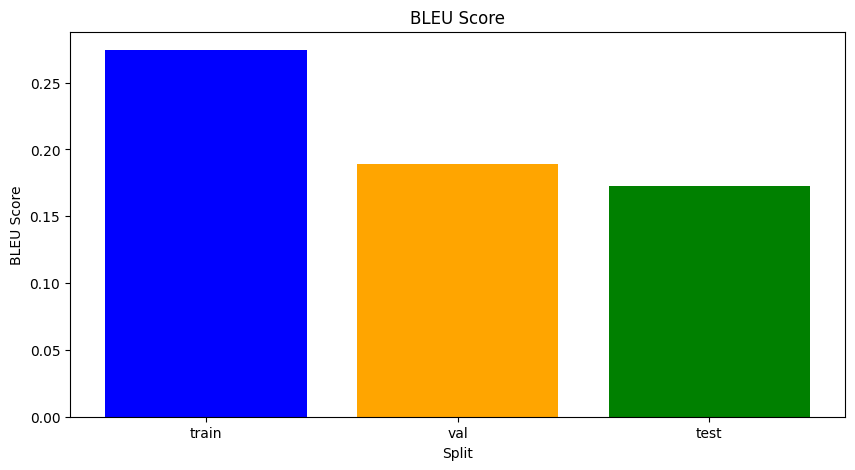

In [ ]:
# Calculate BLEU score
train_bleu_score = bleu.compute(references=train_nlg_df['tgt'].to_list(), predictions=train_nlg_df['hyp'].to_list())
val_bleu_score = bleu.compute(references=val_nlg_df['tgt'].to_list(), predictions=val_nlg_df['hyp'].to_list())
test_bleu_score = bleu.compute(references=test_nlg_df['tgt'].to_list(), predictions=test_nlg_df['hyp'].to_list())

print(f'Train BLEU Score: {train_bleu_score['bleu']:.4f}')
print(f'Val BLEU Score: {val_bleu_score['bleu']:.4f}')
print(f'Test BLEU Score: {test_bleu_score['bleu']:.4f}')

# Plot BLEU score using bar plot
plt.figure(figsize=(10, 5))
plt.bar(['train', 'val', 'test'], [train_bleu_score['bleu'], val_bleu_score['bleu'], test_bleu_score['bleu']], color=['blue', 'orange', 'green'])
plt.xlabel('Split')
plt.ylabel('BLEU Score')
plt.title('BLEU Score')
plt.show()

In [ ]:
# Calculate BERTScore (running on GPU)
train_bertscore_score = bertscore.compute(references=train_nlg_df['tgt'].to_list(), predictions=train_nlg_df['hyp'].to_list(), lang='en')
val_bertscore_score = bertscore.compute(references=val_nlg_df['tgt'].to_list(), predictions=val_nlg_df['hyp'].to_list(), lang='en')
test_bertscore_score = bertscore.compute(references=test_nlg_df['tgt'].to_list(), predictions=test_nlg_df['hyp'].to_list(), lang='en')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metric        Precision    Recall        F1
----------  -----------  --------  --------
Train          0.928317  0.933659  0.930691
Validation     0.913658  0.915746  0.914439
Test           0.916229  0.916142  0.915949


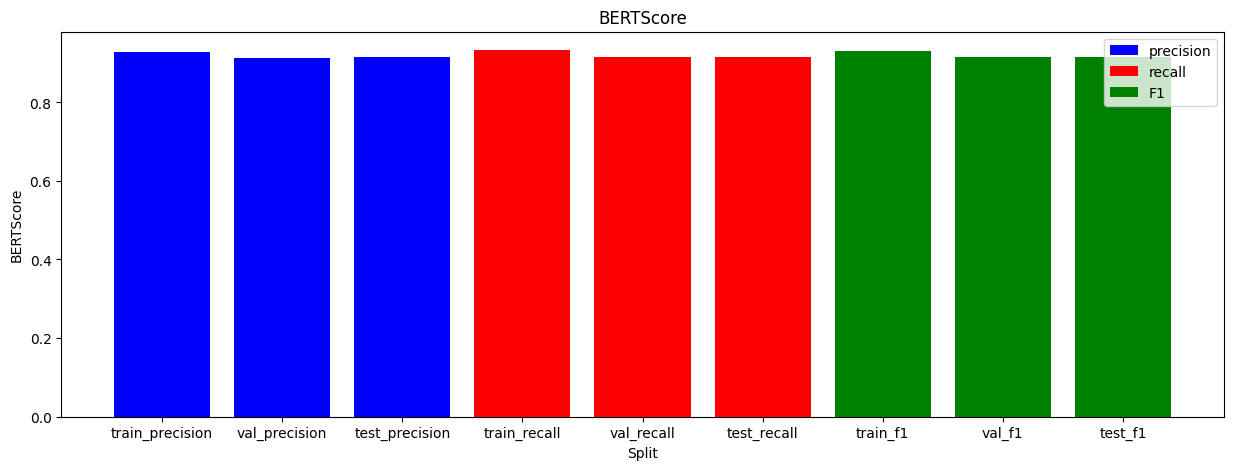

In [ ]:
train_precision = np.mean(train_bertscore_score['precision'])
train_recall = np.mean(train_bertscore_score['recall'])
train_f1 = np.mean(train_bertscore_score['f1'])

val_precision = np.mean(val_bertscore_score['precision'])
val_recall = np.mean(val_bertscore_score['recall'])
val_f1 = np.mean(val_bertscore_score['f1'])

test_precision = np.mean(test_bertscore_score['precision'])
test_recall = np.mean(test_bertscore_score['recall'])
test_f1 = np.mean(test_bertscore_score['f1'])

print(tabulate([['Train', train_precision, train_recall, train_f1], ['Validation', val_precision, val_recall, val_f1], ['Test', test_precision, test_recall, test_f1]], headers=['Metric', 'Precision', 'Recall', 'F1']))


# Plot BERTScore precision, recall, and F1 score using bar plot
plt.figure(figsize=(15, 5))
plt.bar(['train_precision', 'val_precision', 'test_precision'], [train_precision, val_precision, test_precision], color='blue', label='precision')
plt.bar(['train_recall', 'val_recall', 'test_recall'], [train_recall, val_recall, test_recall], color='red', label='recall')
plt.bar(['train_f1', 'val_f1', 'test_f1'], [train_f1, val_f1, test_f1], color='green', label='F1')
plt.xlabel('Split')
plt.ylabel('BERTScore')
plt.title('BERTScore')
plt.legend()
plt.show()

The BLEU score is significantly lower than the BERTScore, as you can see above. A low BLEU score suggests that the model might struggle to match the reference texts' n-grams exactly. High BERTScores, on the other hand, imply that the produced texts exhibit semantic similarity to the reference texts. The difference suggests that while the model successfully captures the general semantic, it might miss certain word selections or phrases that BLEU assesses, which could cause hallucinations.

### Characteritic 4: Annotator Agreement/Disagreement

Here, we will analyze the annotator agreement of the dataset. We will also use the `Krippendorff's Alpha` metric to analyze the annotator agreement.

In [ ]:
val_agg_df = val_df.copy()
test_agg_df = test_df.copy()

In [ ]:
# Plot histogram for agreement score across different tasks
fig = go.Figure()
fig.add_trace(go.Histogram(x=val_agg_df['p(Hallucination)'], name='val', marker_color='blue', opacity=0.5))
fig.add_trace(go.Histogram(x=test_agg_df['p(Hallucination)'], name='test', marker_color='red', opacity=0.5))
fig.update_layout(barmode='group', title='Agreement Score for Hallucination Task')
fig.show()

We now check the p(Hallucination) for each of the MT, DM, and PG tasks to see if there is a significant difference between the tasks.

In [ ]:
# Plot histogram for agreement score across different tasks
## Validation
fig = go.Figure()
fig.add_trace(go.Histogram(x=val_agg_df.loc[val_agg_df['task'] == 'MT', 'p(Hallucination)'], name='MT', marker_color='red', opacity=0.5))
fig.add_trace(go.Histogram(x=val_agg_df.loc[val_agg_df['task'] == 'PG', 'p(Hallucination)'], name='PG', marker_color='blue', opacity=0.5))
fig.add_trace(go.Histogram(x=val_agg_df.loc[val_agg_df['task'] == 'DM', 'p(Hallucination)'], name='DM', marker_color='green', opacity=0.5))
fig.update_layout(barmode='group', title='Validation Agreement Score for Hallucination')
fig.show()

In [ ]:
## Test
fig = go.Figure()
fig.add_trace(go.Histogram(x=test_agg_df.loc[test_agg_df['task'] == 'MT', 'p(Hallucination)'], name='MT', marker_color='red', opacity=0.5))
fig.add_trace(go.Histogram(x=test_agg_df.loc[test_agg_df['task'] == 'PG', 'p(Hallucination)'], name='PG', marker_color='blue', opacity=0.5))
fig.add_trace(go.Histogram(x=test_agg_df.loc[test_agg_df['task'] == 'DM', 'p(Hallucination)'], name='DM', marker_color='green', opacity=0.5))
fig.update_layout(barmode='group', title='Test Agreement Score for Hallucination')
fig.show()

Now let's check how many hallucinations does each annotator make.

In [ ]:
# Plot number of hallucinations by each annotator for each  task
annotators_mt = {'annotator_1': 0, 'annotator_2': 0, 'annotator_3': 0, 'annotator_4': 0, 'annotator_5': 0}
annotators_pg = {'annotator_1': 0, 'annotator_2': 0, 'annotator_3': 0, 'annotator_4': 0, 'annotator_5': 0}
annotators_dm = {'annotator_1': 0, 'annotator_2': 0, 'annotator_3': 0, 'annotator_4': 0, 'annotator_5': 0}

for i in range(1, 6):
    for j in range(val_agg_df.shape[0]):
        if val_agg_df['task'][j] == 'MT':
            if val_agg_df['labels'][j][i-1] == 'Hallucination':
                annotators_mt[f'annotator_{i}'] += 1
        elif val_agg_df['task'][j] == 'PG':
            if val_agg_df['labels'][j][i-1] == 'Hallucination':
                annotators_pg[f'annotator_{i}'] += 1
        elif val_agg_df['task'][j] == 'DM':
            if val_agg_df['labels'][j][i-1] == 'Hallucination':
                annotators_dm[f'annotator_{i}'] += 1
    for j in range(test_agg_df.shape[0]):
        if test_agg_df['task'][j] == 'MT':
            if test_agg_df['labels'][j][i-1] == 'Hallucination':
                annotators_mt[f'annotator_{i}'] += 1
        elif test_agg_df['task'][j] == 'PG':
            if test_agg_df['labels'][j][i-1] == 'Hallucination':
                annotators_pg[f'annotator_{i}'] += 1
        elif test_agg_df['task'][j] == 'DM':
            if test_agg_df['labels'][j][i-1] == 'Hallucination':
                annotators_dm[f'annotator_{i}'] += 1

annotators_df = pd.DataFrame([annotators_mt, annotators_pg, annotators_dm], index=['MT', 'PG', 'DM'])
fig = go.Figure()
fig.add_trace(go.Bar(x=annotators_df.columns, y=annotators_df.loc['MT'], name='MT', marker_color='red'))
fig.add_trace(go.Bar(x=annotators_df.columns, y=annotators_df.loc['PG'], name='PG', marker_color='blue'))
fig.add_trace(go.Bar(x=annotators_df.columns, y=annotators_df.loc['DM'], name='DM', marker_color='green'))
fig.update_layout(barmode='group', title='Number of Hallucinations by Each Annotator for Each Task')

Now let's check the annotator agreement using Krippendorff's Alpha.

In [ ]:
from nltk.metrics import agreement

# Calculate agreement score for hallucination task
## Validation
val_hallucination_labels = val_agg_df['labels'].to_list()
val_hallucination_labels = [[1 if label == 'Hallucination' else 0 for label in labels] for labels in val_hallucination_labels]
val_hallucination_annotator = list(map(list, zip(*val_hallucination_labels)))
val_hallucination_item = []
for i in range(len(val_hallucination_annotator)):
    for j in range(len(val_hallucination_annotator[i])):
        val_hallucination_item.append((f'annotator_{i+1}', j, val_hallucination_annotator[i][j]))
val_hallucination_task = agreement.AnnotationTask(data=val_hallucination_item)
val_hallucination_agreement = val_hallucination_task.alpha()
print(f'Validation Krippendorff\'s Alpha: {val_hallucination_agreement:.4f}')

Validation Krippendorff's Alpha: 0.3730


In [ ]:
## Test
test_hallucination_labels = test_agg_df['labels'].to_list()
test_hallucination_labels = [[1 if label == 'Hallucination' else 0 for label in labels] for labels in test_hallucination_labels]
test_hallucination_annotator = list(map(list, zip(*test_hallucination_labels)))
test_hallucination_item = []
for i in range(len(test_hallucination_annotator)):
    for j in range(len(test_hallucination_annotator[i])):
        test_hallucination_item.append((f'annotator_{i+1}', j, test_hallucination_annotator[i][j]))
test_hallucination_task = agreement.AnnotationTask(data=test_hallucination_item)
test_hallucination_agreement = test_hallucination_task.alpha()
print(f'Test Krippendorff\'s Alpha: {test_hallucination_agreement:.4f}')

Test Krippendorff's Alpha: 0.3695


Now let's interpret the findings:
First, we can see that the disaggreement for the DM task is significantly higher than the MT and PG tasks as shown by p(Hallucination). This suggests that the DM task might be more challenging for the annotators.

Second, we can see that annotators have roughly the same number of hallucinations for each task. This suggests that the hallucination rate is consistent across the tasks and that an annotator is not biased towards hallucinating more in one task than the other.

Finally, we can see that the Krippendorff's Alpha is about 0.37, which is relatively low. This suggests that the annotator agreement is low, as that is obviously the case for the DM task which accounts for 1/3 of the dataset. This shows that the dataset (esp. DM task) is relatively challenging even for the human annotators.

### Characteritic 5: Sentiment Analysis

Here, we will analyze the sentiment of the dataset. We will use the `Transformers` and `TextBlob` libraries to analyze the sentiment and subjectivity of the dataset.

In [22]:
# This section is better to be runned by GPU

from transformers import pipeline

sentiment_analyzer = pipeline("sentiment-analysis", model='cardiffnlp/twitter-roberta-base-sentiment-latest', device=0)

# Clone and copy src to tgt where task is PG
train_df_sa = train_df.copy()
val_df_sa = val_df.copy()
test_df_sa = test_df.copy()
train_df_sa.loc[train_df_sa['task'] == 'PG', 'tgt'] = train_df_sa.loc[train_df_sa['task'] == 'PG', 'src']
val_df_sa.loc[val_df_sa['task'] == 'PG', 'tgt'] = val_df_sa.loc[val_df_sa['task'] == 'PG', 'src']
test_df_sa.loc[test_df_sa['task'] == 'PG', 'tgt'] = test_df_sa.loc[test_df_sa['task'] == 'PG', 'src']

train_df_sa.head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,hyp,tgt,src,ref,task,model
0,"Don't worry, it's only temporary.",Don't worry. It's only temporary.,Не волнуйся. Это только временно.,either,MT,
1,Tom is never where he should be.,Tom is never where he's supposed to be.,"Тома никогда нет там, где он должен быть.",either,MT,
2,It's hard for me to work with Tom.,I have trouble working with Tom.,Мне сложно работать с Томом.,either,MT,
3,"Water, please.",I'd like some water.,"Воду, пожалуйста.",either,MT,
4,I didn't expect Tom to betray me.,I didn't think that Tom would betray me.,"Я не ожидал, что Том предаст меня.",either,MT,


In [25]:
## Hypothesis

train_hyp_sa = sentiment_analyzer(train_df_sa['hyp'].to_list(), batch_size=32)
val_hyp_sa = sentiment_analyzer(val_df_sa['hyp'].to_list(), batch_size=32)
test_hyp_sa = sentiment_analyzer(test_df_sa['hyp'].to_list(), batch_size=32)

## Target

train_tgt_sa = sentiment_analyzer(train_df_sa['tgt'].to_list(), batch_size=32)
val_tgt_sa = sentiment_analyzer(val_df_sa['tgt'].to_list(), batch_size=32)
test_tgt_sa = sentiment_analyzer(test_df_sa['tgt'].to_list(), batch_size=32)

In [24]:
# Plot bar chart

fig = go.Figure()
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in train_hyp_sa if sa['label'] == 'positive']), len([1 for sa in train_hyp_sa if sa['label'] == 'negative']), len([1 for sa in train_hyp_sa if sa['label'] == 'neutral'])], name='train_hyp', marker_color='blue'))
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in val_hyp_sa if sa['label'] == 'positive']), len([1 for sa in val_hyp_sa if sa['label'] == 'negative']), len([1 for sa in val_hyp_sa if sa['label'] == 'neutral'])], name='val_hyp', marker_color='orange'))
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in test_hyp_sa if sa['label'] == 'positive']), len([1 for sa in test_hyp_sa if sa['label'] == 'negative']), len([1 for sa in test_hyp_sa if sa['label'] == 'neutral'])], name='test_hyp', marker_color='green'))
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in train_tgt_sa if sa['label'] == 'positive']), len([1 for sa in train_tgt_sa if sa['label'] == 'negative']), len([1 for sa in train_tgt_sa if sa['label'] == 'neutral'])], name='train_tgt', marker_color='red'))
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in val_tgt_sa if sa['label'] == 'positive']), len([1 for sa in val_tgt_sa if sa['label'] == 'negative']), len([1 for sa in val_tgt_sa if sa['label'] == 'neutral'])], name='val_tgt', marker_color='purple'))
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in test_tgt_sa if sa['label'] == 'positive']), len([1 for sa in test_tgt_sa if sa['label'] == 'negative']), len([1 for sa in test_tgt_sa if sa['label'] == 'neutral'])], name='test_tgt', marker_color='brown'))
fig.update_layout(barmode='group', title='Sentiment Analysis for Hypothesis and Target Text')
fig.show()

Now, let's investigate the subjectivity of the dataset.

In [25]:
from textblob import TextBlob

train_df_sa['hyp_subjectivity'] = train_df_sa['hyp'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
train_df_sa['tgt_subjectivity'] = train_df_sa['tgt'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

val_df_sa['hyp_subjectivity'] = val_df_sa['hyp'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
val_df_sa['tgt_subjectivity'] = val_df_sa['tgt'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

test_df_sa['hyp_subjectivity'] = test_df_sa['hyp'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test_df_sa['tgt_subjectivity'] = test_df_sa['tgt'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

train_df_sa.head()

,hyp,tgt,src,ref,task,model,hyp_neg,hyp_neu,hyp_pos,hyp_compound,tgt_neg,tgt_neu,tgt_pos,tgt_compound,hyp_subjectivity,tgt_subjectivity
0,"Don't worry, it's only temporary.",Don't worry. It's only temporary.,Не волнуйся. Это только временно.,either,MT,,0.000,0.624,0.376,0.3412,0.000,0.624,0.376,0.3412,1.000000,1.0
1,Tom is never where he should be.,Tom is never where he's supposed to be.,"Тома никогда нет там, где он должен быть.",either,MT,,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000,0.000000,0.0
2,It's hard for me to work with Tom.,I have trouble working with Tom.,Мне сложно работать с Томом.,either,MT,,0.167,0.833,0.000,-0.1027,0.351,0.649,0.000,-0.4019,0.541667,0.2
3,"Water, please.",I'd like some water.,"Воду, пожалуйста.",either,MT,,0.000,0.303,0.697,0.3182,0.000,0.545,0.455,0.3612,0.000000,0.0
4,I didn't expect Tom to betray me.,I didn't think that Tom would betray me.,"Я не ожидал, что Том предаст меня.",either,MT,,0.412,0.588,0.000,-0.6369,0.375,0.625,0.000,-0.6369,0.000000,0.0


In [26]:
# Plot bar chart

fig = go.Figure()
fig.add_trace(go.Histogram(x=train_df_sa['hyp_subjectivity'], name='train_hyp', nbinsx=10))
fig.add_trace(go.Histogram(x=train_df_sa['tgt_subjectivity'], name='train_tgt', nbinsx=10))
fig.add_trace(go.Histogram(x=val_df_sa['hyp_subjectivity'], name='val_hyp', nbinsx=10))
fig.add_trace(go.Histogram(x=val_df_sa['tgt_subjectivity'], name='val_tgt', nbinsx=10))
fig.add_trace(go.Histogram(x=test_df_sa['hyp_subjectivity'], name='test_hyp', nbinsx=10))
fig.add_trace(go.Histogram(x=test_df_sa['tgt_subjectivity'], name='test_tgt', nbinsx=10))
fig.update_layout(barmode='group', title='Subjectivity Analysis')
fig.show()

Now, let's investigate the sentiment distribution of the hallucinations.

In [30]:
# Get rows with high p(Hallucination)
val_df_sa_hallucination = val_df_sa[val_df_sa['p(Hallucination)'] > 0.5]
test_df_sa_hallucination = test_df_sa[test_df_sa['p(Hallucination)'] > 0.5]

## Hypothesis
val_hyp_sa = sentiment_analyzer(val_df_sa_hallucination['hyp'].to_list(), batch_size=32)
test_hyp_sa = sentiment_analyzer(test_df_sa_hallucination['hyp'].to_list(), batch_size=32)

## Target
val_tgt_sa = sentiment_analyzer(val_df_sa_hallucination['tgt'].to_list(), batch_size=32)
test_tgt_sa = sentiment_analyzer(test_df_sa_hallucination['tgt'].to_list(), batch_size=32)

# Plot bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in val_hyp_sa if sa['label'] == 'positive']), len([1 for sa in val_hyp_sa if sa['label'] == 'negative']), len([1 for sa in val_hyp_sa if sa['label'] == 'neutral'])], name='val_hyp', marker_color='orange'))
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in val_tgt_sa if sa['label'] == 'positive']), len([1 for sa in val_tgt_sa if sa['label'] == 'negative']), len([1 for sa in val_tgt_sa if sa['label'] == 'neutral'])], name='val_tgt', marker_color='purple'))
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in test_hyp_sa if sa['label'] == 'positive']), len([1 for sa in test_hyp_sa if sa['label'] == 'negative']), len([1 for sa in test_hyp_sa if sa['label'] == 'neutral'])], name='test_hyp', marker_color='green'))
fig.add_trace(go.Bar(x=['Positive', 'Negative', 'Neutral'], y=[len([1 for sa in test_tgt_sa if sa['label'] == 'positive']), len([1 for sa in test_tgt_sa if sa['label'] == 'negative']), len([1 for sa in test_tgt_sa if sa['label'] == 'neutral'])], name='test_tgt', marker_color='brown'))
fig.update_layout(barmode='group', title='Sentiment Analysis for Hallucination Hypothesis and Target Text')
fig.show()

As we can see, the sentiment distribution is not significantly different between the hypothesis and the target. However, we can see in the last plot that among the hallucination cases, both val and test hypothesis tend to be more positive than val and test target. This might point out that at least some of the hallucinations might be because of this sentiment shift generated by the model to make the sentence more positive. In addition, as we can see above, the dataset is mostly objective.